In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Call Libraries
import scipy
import numpy as np
import matplotlib as plt
import pandas as pd
import sklearn

In [7]:
import os

# Define the base path to data
base_path = '/content/drive/MyDrive/SoundCloud'

# Read each file into its own DataFrame
affiliations = pd.read_csv(os.path.join(base_path, 'affiliations.csv'))
comments = pd.read_csv(os.path.join(base_path, 'comments.csv'))
favoritings = pd.read_csv(os.path.join(base_path, 'favoritings.csv'))
creators_df = pd.read_csv(os.path.join(base_path, 'creator_ids.csv'))

In [ ]:
# Extract the creator IDs as a list or Series for use in functions
creators = creators_df['creator_id'].unique()

In [8]:
# Peek at Data
display(affiliations.head())
display(comments.head())
display(favoritings.head())
display(creators_df.head())

,Unnamed: 0,creator_id,fan_id,contact_id,created_at
0,1,54849.0,55250,45724,02-01-2009 15:14
1,2,54869.0,55250,2629,02-01-2009 15:15
2,3,54882.0,55250,4230,02-01-2009 15:15
3,4,54901.0,55250,3082,02-01-2009 15:16
4,5,54912.0,55250,3107,02-01-2009 15:16


,Unnamed: 0,user_id,track_id,owner_id,created_at
0,1,56125,4912,274,2009-01-06 11:57:50
1,2,54181,116480,61390,2009-01-27 02:45:05
2,3,3983,125334,64864,2009-02-08 18:04:24
3,4,65739,140931,65739,2009-02-11 21:36:27
4,5,65739,140931,65739,2009-02-11 21:40:18


,Unnamed: 0,user_id,track_id,owner_id,created_at
0,1,55806,98214,54084,2009-01-03 23:47:10
1,2,56588,100073,2153,2009-01-07 18:14:02
2,3,57524,103677,57276,2009-01-08 00:18:19
3,4,58048,58062,29763,2009-01-11 18:06:08
4,5,60584,55187,31543,2009-01-16 18:16:40


,creator_id,type
0,54849,creator
1,54869,creator
2,54882,creator
3,54901,creator
4,54912,creator


#### **Define Parameters**
- Threshold = Cut-off for number of followers
- Window-Days = Days since influencer crosses threshold
- Top_K = Number of creators 'k' to be viewed

In [9]:
THRESHOLD = 100
WINDOW_DAYS = 180
TOP_K = 10

#### **Sorting Affiliations by timestamps**
- Clean the affiliations (follow) dataset.
- Keep only fan_id, contact_id, and created_at.
- Convert timestamps to datetime.
- Coerces IDs to numeric, remove missing values, sort by time, and drop duplicate follow edges.

**Output:** Time-ordered follower-following relationships.

In [12]:
def prep_affiliations(affiliations):
    a = affiliations[["fan_id", "contact_id", "created_at"]].copy()
    a["created_at"] = pd.to_datetime(a["created_at"], errors="coerce")
    a = a.dropna(subset=["fan_id", "contact_id", "created_at"])
    a["fan_id"] = pd.to_numeric(a["fan_id"], errors="coerce")
    a["contact_id"] = pd.to_numeric(a["contact_id"], errors="coerce")
    a = a.dropna(subset=["fan_id", "contact_id"])
    a = a.sort_values("created_at")
    a = a.drop_duplicates(subset=["fan_id", "contact_id"], keep="first")
    return a

display(prep_affiliations(affiliations))

,fan_id,contact_id,created_at
38480,54848,14730,2009-01-01 01:01:00
39220,54846,4610,2009-01-01 02:12:00
39221,54846,6281,2009-01-01 02:13:00
39222,54846,15386,2009-01-01 02:17:00
39223,54846,1214,2009-01-01 02:25:00
...,...,...,...
406914,65751,230093,2010-12-12 23:37:00
406915,570983,56512,2010-12-12 23:58:00
406916,1157665,72642,2010-12-12 23:59:00
406918,1157665,63463,2010-12-12 23:59:00


#### **Time-ordered list of creators**
- Computes when each creator reaches a follower threshold.
- Filters follow events to creators.
- Sorts follower arrivals chronologically.
- Assigns cumulative follower ranks per creator.
- Selects the timestamp when the rank equals the predefined threshold.

**Ouput:** Series mapping each creator to their threshold-crossing time.

In [13]:
def compute_tcross(a, creators):
    fe = a[a["contact_id"].isin(creators)].copy()
    fe = fe.sort_values(["contact_id", "created_at"])
    fe["rank"] = fe.groupby("contact_id").cumcount() + 1

    tcross = (
        fe[fe["rank"] == THRESHOLD]
        .set_index("contact_id")["created_at"]
    )
    tcross.name = "tcross"
    return tcross

display(compute_tcross(affiliations, creators))

,tcross
contact_id,
54952,03-07-2009 12:13
54964,28-12-2009 13:23
54966,23-08-2009 22:05
54976,13-04-2010 11:05
54989,09-09-2009 02:08
...,...
93557,05-06-2009 07:01
93580,09-09-2009 08:05
93672,09-10-2009 14:40


#### **Compute Reciprocal Ties**
- Identifies reciprocal (mutual) follow ties among creators.
- Extract directed follow edges
- Filter them to creator–creator relationships
- Perform a *self-merge* with reversed edges to retain only pairs where both users follow each other.

**Output:** Produce a clean set of reciprocal strong-tie candidates.

In [14]:
def reciprocal_ties(a, creators):
    # Extracts directed follow edges
    edges = a[["fan_id", "contact_id"]].copy()
    # Renames as a directed edge u → v
    edges = edges.rename(columns={"fan_id": "u", "contact_id": "v"})
    # Filter analysis to keep creator–creator relationships
    edges = edges[
        edges["u"].isin(creators) &
        edges["v"].isin(creators)
    ]

    # Strong ties: Match each edge with its reversed counterpart (v → u)
    recip = edges.merge(
        edges.rename(columns={"u": "v", "v": "u"}),
        on=["u", "v"],
        how="inner"
    )

    return recip.drop_duplicates()

display(reciprocal_ties(affiliations, creators))

,u,v
0,56775,57376
1,57572,58696
2,59096,59531
3,60338,56788
4,60071,63020
...,...,...
10781,76589,74520
10782,76589,55420
10783,77563,79443
10784,73309,57305


####**Sort, clean, and merge comments and  datasets**
- Convert timestamps, remove missing or invalid IDs.
- Excludes self-interactions.
- Rename columns to a consistent source–target format.
- Concatenate both datasets.

**Output:** Single time-ordered interaction table for tie-intensity analysis.

In [15]:
def build_interactions(comments, favoritings):
    def clean(df):
        df = df[["user_id", "owner_id", "created_at"]].copy()
        df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
        df = df.dropna(subset=["user_id", "owner_id", "created_at"])
        df["user_id"] = pd.to_numeric(df["user_id"], errors="coerce")
        df["owner_id"] = pd.to_numeric(df["owner_id"], errors="coerce")
        df = df.dropna(subset=["user_id", "owner_id"])
        # Remove self-interactions
        df = df[df["user_id"] != df["owner_id"]]
        df = df.rename(columns={
            "user_id": "source",
            "owner_id": "target",
            "created_at": "time"
        })
        return df

    c = clean(comments)
    f = clean(favoritings)

    interactions = pd.concat([c, f], ignore_index=True)
    return interactions.sort_values(["source", "time"])

display(build_interactions(comments, favoritings))

,source,target,time
3042122,2,76216,2011-02-19 14:35:09
3042130,2,76216,2011-02-19 18:23:13
3301261,2,57318,2011-05-28 08:29:34
3301343,2,80522,2011-05-29 20:56:03
3414646,2,54952,2011-07-09 09:46:21
...,...,...,...
13307199,85281025,62100,2014-03-19 01:41:16
13310752,85281224,62864,2014-03-19 01:41:30
13048277,85281239,80872,2014-03-19 01:47:30
13310756,85281407,79481,2014-03-19 01:46:09


In [19]:
def intensity_pre_post(interactions, recip, tcross):

    # Keep only creators who crossed threshold
    crossed = tcross.index
    recip = recip[recip["u"].isin(crossed)].copy()

    # Attach tcross to edges
    recip = recip.merge(
        tcross.reset_index(),
        left_on="u",
        right_on="contact_id",
        how="inner"
    ).rename(columns={"contact_id": "creator_id"})

    # Use dayfirst=True to handle the DD-MM-YYYY format in the data
    recip["tcross"] = pd.to_datetime(recip["tcross"], dayfirst=True)
    recip["post_end"] = recip["tcross"] + pd.Timedelta(days=WINDOW_DAYS)

    # Match interactions along reciprocal edges
    ev = interactions.merge(
        recip[["u", "v", "tcross", "post_end"]],
        left_on=["source", "target"],
        right_on=["u", "v"],
        how="inner"
    )

    # Ensure interaction times are also datetime for comparison
    ev["time"] = pd.to_datetime(ev["time"], dayfirst=True)

    pre = ev["time"] < ev["tcross"]
    post = (ev["time"] >= ev["tcross"]) & (ev["time"] <= ev["post_end"])

    ev = ev[pre | post].copy()
    ev["window"] = np.where(pre.loc[ev.index], "pre", "post")

    pre_counts = (
        ev[ev["window"] == "pre"]
        .groupby(["u", "v"])
        .size()
        .rename("intensity_pre")
    )

    post_counts = (
        ev[ev["window"] == "post"]
        .groupby(["u", "v"])
        .size()
        .rename("intensity_post")
    )

    out = pd.concat([pre_counts, post_counts], axis=1).fillna(0).reset_index()

    return out

display(intensity_pre_post(build_interactions(comments, favoritings), reciprocal_ties(affiliations, creators), compute_tcross(affiliations, creators)))

,u,v,intensity_pre,intensity_post
0,54966,56041,1.0,0.0
1,55101,55773,3.0,1.0
2,55101,57534,3.0,0.0
3,55323,83300,1.0,0.0
4,55382,56200,2.0,0.0
...,...,...,...,...
544,92293,79680,0.0,1.0
545,92434,62198,0.0,1.0
546,92760,61620,0.0,1.0
547,93412,83629,0.0,1.0


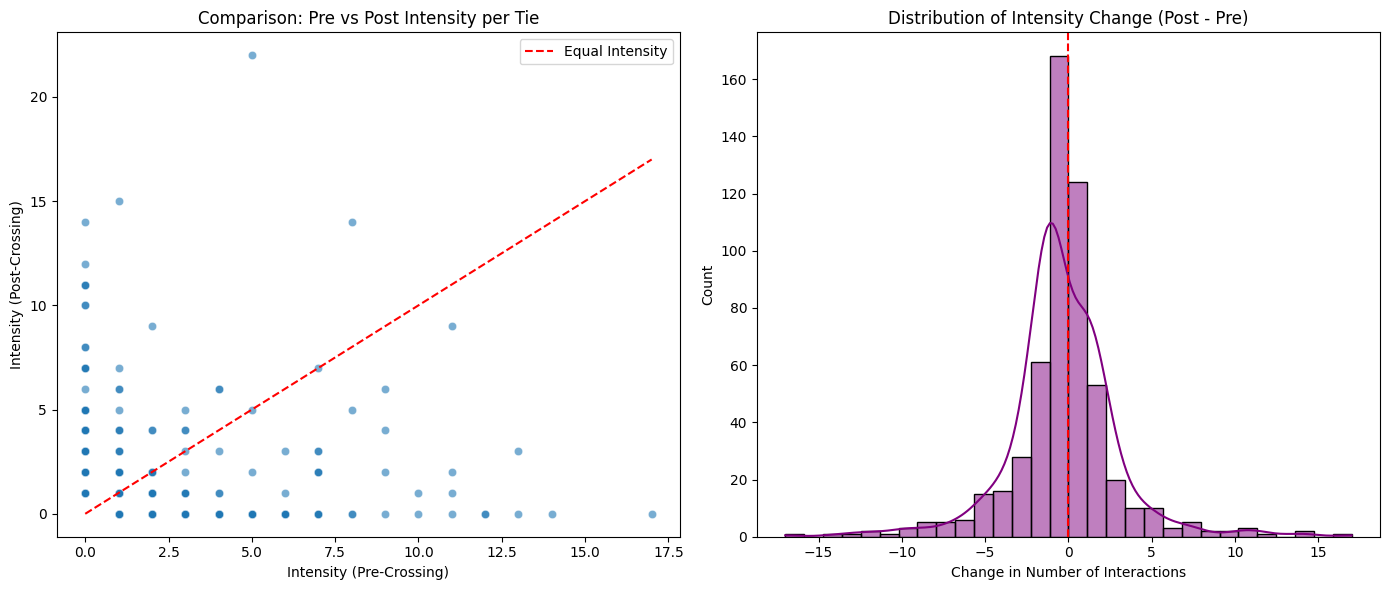

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the intensity data
interactions_df = build_interactions(comments, favoritings)
recip_df = reciprocal_ties(affiliations, creators)
tcross_df = compute_tcross(affiliations, creators)
intensity_data = intensity_pre_post(interactions_df, recip_df, tcross_df)

# Create the visualization
plt.figure(figsize=(14, 6))

# Subplot 1: Scatter plot of Pre vs Post intensity
plt.subplot(1, 2, 1)
sns.scatterplot(data=intensity_data, x='intensity_pre', y='intensity_post', alpha=0.6)
plt.plot([0, intensity_data['intensity_pre'].max()], [0, intensity_data['intensity_pre'].max()], 'r--', label='Equal Intensity')
plt.title('Comparison: Pre vs Post Intensity per Tie')
plt.xlabel('Intensity (Pre-Crossing)')
plt.ylabel('Intensity (Post-Crossing)')
plt.legend()

# Subplot 2: Distribution of changes
plt.subplot(1, 2, 2)
intensity_data['change'] = intensity_data['intensity_post'] - intensity_data['intensity_pre']
sns.histplot(intensity_data['change'], bins=30, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Intensity Change (Post - Pre)')
plt.xlabel('Change in Number of Interactions')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


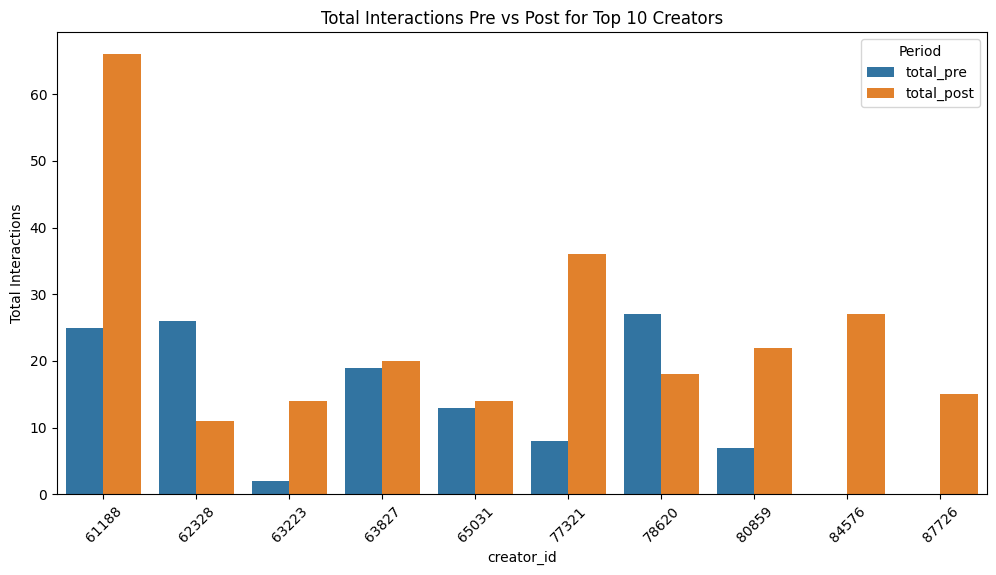

In [22]:
def tie_metrics(intensity_uv):
    results = []
    for u, g in intensity_uv.groupby("u"):
        g = g.copy()
        pre_top = g.sort_values("intensity_pre", ascending=False).head(TOP_K)["v"]
        post_top = g.sort_values("intensity_post", ascending=False).head(TOP_K)["v"]
        overlap = len(set(pre_top).intersection(set(post_top))) / min(TOP_K, len(pre_top)) if len(pre_top) > 0 else 0
        rho = np.nan
        if len(g) >= 2:
            rho = g["intensity_pre"].corr(g["intensity_post"], method="spearman")
        results.append({
            "creator_id": u,
            "n_partners": len(g),
            "topk_overlap": overlap,
            "spearman_rank_corr": rho,
            "total_pre": g["intensity_pre"].sum(),
            "total_post": g["intensity_post"].sum()
        })
    return pd.DataFrame(results)

# Aggregate by creator to see overall impact
metrics = tie_metrics(intensity_data)
top_creators = metrics.sort_values('total_post', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_melted = top_creators.melt(id_vars='creator_id', value_vars=['total_pre', 'total_post'],
                              var_name='Period', value_name='Total Interactions')

sns.barplot(data=top_melted, x='creator_id', y='Total Interactions', hue='Period')
plt.title('Total Interactions Pre vs Post for Top 10 Creators')
plt.xticks(rotation=45)
plt.show()

In [23]:
def partner_switching_metrics(interactions, tcross, min_pre_partners=0):

    # Keep only creators who crossed threshold
    crossed = tcross.index
    ev = interactions[interactions["source"].isin(crossed)].copy()

    # Attach tcross
    ev = ev.merge(
        tcross.reset_index(),
        left_on="source",
        right_on="contact_id",
        how="inner"
    )

    # Ensure datetime
    ev["time"] = pd.to_datetime(ev["time"], dayfirst=True)
    ev["tcross"] = pd.to_datetime(ev["tcross"], dayfirst=True)

    # Define windows
    ev["window"] = np.where(ev["time"] < ev["tcross"], "pre", "post")

    results = []

    for u, g in ev.groupby("source"):

        pre_partners = set(g[g["window"] == "pre"]["target"])
        post_partners = set(g[g["window"] == "post"]["target"])

        if len(pre_partners) < min_pre_partners:
            continue

        union = pre_partners.union(post_partners)
        intersection = pre_partners.intersection(post_partners)

        jaccard = len(intersection) / len(union) if len(union) > 0 else np.nan
        new_share = len(post_partners - pre_partners) / len(post_partners) if len(post_partners) > 0 else np.nan

        results.append({
            "creator_id": u,
            "n_pre_partners": len(pre_partners),
            "n_post_partners": len(post_partners),
            "jaccard_similarity": jaccard,
            "new_partner_share": new_share
        })

    return pd.DataFrame(results)

display(partner_switching_metrics(build_interactions(comments, favoritings), compute_tcross(affiliations, creators)))

,creator_id,n_pre_partners,n_post_partners,jaccard_similarity,new_partner_share
0,54952,0,40,0.000000,1.000000
1,54964,1,17,0.000000,1.000000
2,54966,45,42,0.087500,0.833333
3,54976,5,35,0.081081,0.914286
4,54989,0,8,0.000000,1.000000
...,...,...,...,...,...
1223,93540,22,175,0.053476,0.942857
1224,93557,5,78,0.000000,1.000000
1225,93580,6,40,0.045455,0.950000
1226,93672,0,5,0.000000,1.000000
